In [1]:
import sys
sys.path.append("..")
import src.sim
import src.strategy
import src.clearing
from src.plot import SimulationVisualizer

In [2]:
import datetime
from typing import Dict, List, Any
from src.clearing import ClearingMechanism

class MinimalClearing(ClearingMechanism):
    """Extremely simple clearing that only matches orders with identical prices."""
    
    def clear(self, current_time: datetime.datetime, active_orders: Dict[str, Any]) -> List[Any]:
        """Match orders with identical prices for the same contract time.
        
        Args:
            current_time: Current simulation time
            active_orders: Dictionary of all active orders
            
        Returns:
            List of orders that were filled
        """
        filled_orders = []
        
        # Group orders by contract time and price
        by_contract_price = {}
        for order in active_orders.values():
            key = (order.contract_time, order.price)
            if key not in by_contract_price:
                by_contract_price[key] = {'buy': [], 'sell': []}
            by_contract_price[key][order.side].append(order)
        
        # Match orders with identical price
        for (contract_time, price), sides in by_contract_price.items():
            buys = sides['buy']
            sells = sides['sell']
            
            # If we have both buys and sells at this price, match them
            while buys and sells:
                buy = buys.pop(0)
                sell = sells.pop(0)
                
                # Set execution price
                buy.execution_price = price
                sell.execution_price = price
                
                # Add to filled orders
                filled_orders.append(buy)
                filled_orders.append(sell)
        
        return filled_orders

In [3]:
import datetime
from typing import List, Tuple
from src.strategy import Strategy

class FixedOrderStrategy(Strategy):
    """Minimal strategy that places a single order once."""
    
    def __init__(self, price=50.0, quantity=1, side='buy'):
        """Initialize with fixed order parameters."""
        super().__init__()
        self.price = price
        self.quantity = quantity
        self.side = side
        self.has_placed_order = False
    
    def update_orders(self, current_time: datetime.datetime) -> Tuple[List, List, List]:
        """Place a single order on the first call, then do nothing."""
        if not self.has_placed_order:
            # Create contract time 1 hour ahead
            contract_time = current_time + datetime.timedelta(hours=1)
            
            # Create order
            order = self.create_order(
                price=self.price,
                quantity=self.quantity,
                contract_time=contract_time,
                side=self.side
            )
            
            return [order], [], []
        else:
            return [], [], []

In [4]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from src.sim import TradingSimulation

# Setup simulation timeframe (just 3 steps)
start_time = datetime.datetime(2023, 1, 1, 10, 0)
end_time = datetime.datetime(2023, 1, 1, 15, 30)
time_step = datetime.timedelta(minutes=15)

# Create two strategies with matching prices
buy_strategy = FixedOrderStrategy(price=50.0, quantity=1, side='buy')
sell_strategy = FixedOrderStrategy(price=50.0, quantity=1, side='sell')

# Create minimal clearing mechanism
clearing = MinimalClearing()

# Setup and run simulation
sim = TradingSimulation(
    start_time=start_time,
    end_time=end_time,
    time_step=time_step,
    strategies=[buy_strategy, sell_strategy],
    clearing_mechanism=clearing
)


# After running simulation
results = sim.run()
metrics = sim.analyze()

# Create visualizer
from src.plot import SimulationVisualizer
viz = SimulationVisualizer(metrics, results)

# View all plots organized by strategy
viz.create_dashboard().show()

# Or view specific plots
viz.plot_buy_orders(strategy_id=buy_strategy.id).show()
viz.plot_sell_orders(strategy_id=sell_strategy.id).show()

# Or get specific metrics
fill_rates = sim.analyze(metrics=["fill_rate"])

# Display fill rates by strategy
print("Fill rates by strategy:")
for strategy_id, data in fill_rates["fill_rate"].items():
    print(f"{strategy_id}: {data['fill_rate']:.2%}")

# Visualize time to fill
time_to_fill = sim.analyze(metrics=["time_to_fill"])

# Create a bar chart of mean time to fill by strategy
plt.figure(figsize=(10, 6))
strategies = []
times = []

for strategy_id, data in time_to_fill["time_to_fill"].items():
    if 'mean_seconds' in data:  # Check if there were filled orders
        strategies.append(strategy_id)
        times.append(data['mean_seconds'])


# Compare execution prices
execution_prices = sim.analyze(metrics=["execution_prices"])


2025-04-21 12:35:28,798 - TradingSimulation - INFO - Starting simulation from 2023-01-01 10:00:00 to 2023-01-01 15:30:00
2025-04-21 12:35:28,802 - TradingSimulation - INFO - Simulation complete


Order history shape: (90, 12)
Total events: 90, Unique orders: 46
Event type counts:
event_type
submitted    46
filled       44
Name: count, dtype: int64
Status counts:
status
active    46
filled    44
Name: count, dtype: int64
Metrics fill_rate data:
  f6b3ddd2-b02a-4530-b78b-438b3dbbcc35: {'submitted_orders': 23, 'filled_orders': 22, 'fill_rate': 0.9565217391304348}
  4e455779-ffb0-4c76-acb9-af8da297dc19: {'submitted_orders': 23, 'filled_orders': 22, 'fill_rate': 0.9565217391304348}

Fill counts by strategy:
  f6b3ddd2-b02a-4530-b78b-438b3dbbcc35: 22/23 (95.7% filled)
  4e455779-ffb0-4c76-acb9-af8da297dc19: 22/23 (95.7% filled)
[{'Strategy': 'f6b3ddd2-b02a-4530-b78b-438b3dbbcc35', 'Fill Rate': '95.7%', 'VWAP': '50.00', 'Buy VWAP': '50.00', 'Sell VWAP': '', 'Avg Time to Fill (s)': '', 'Volume': '22'}, {'Strategy': '4e455779-ffb0-4c76-acb9-af8da297dc19', 'Fill Rate': '95.7%', 'VWAP': '50.00', 'Buy VWAP': '', 'Sell VWAP': '50.00', 'Avg Time to Fill (s)': '', 'Volume': '22'}]


Fill rates by strategy:
f6b3ddd2-b02a-4530-b78b-438b3dbbcc35: 95.65%
4e455779-ffb0-4c76-acb9-af8da297dc19: 95.65%


<Figure size 1000x600 with 0 Axes>

In [5]:
metrics

{'fill_rate': {'f6b3ddd2-b02a-4530-b78b-438b3dbbcc35': {'submitted_orders': 23,
   'filled_orders': 22,
   'fill_rate': 0.9565217391304348},
  '4e455779-ffb0-4c76-acb9-af8da297dc19': {'submitted_orders': 23,
   'filled_orders': 22,
   'fill_rate': 0.9565217391304348}},
 'time_to_fill': {'f6b3ddd2-b02a-4530-b78b-438b3dbbcc35': {'mean_minutes': np.float64(15.0),
   'median_minutes': np.float64(15.0),
   'min_minutes': np.float64(15.0),
   'max_minutes': np.float64(15.0),
   'count': 22},
  '4e455779-ffb0-4c76-acb9-af8da297dc19': {'mean_minutes': np.float64(15.0),
   'median_minutes': np.float64(15.0),
   'min_minutes': np.float64(15.0),
   'max_minutes': np.float64(15.0),
   'count': 22}},
 'contract_volume': {'f6b3ddd2-b02a-4530-b78b-438b3dbbcc35': {'total_volume': np.int64(22),
   'by_contract': {Timestamp('2023-01-01 11:00:00'): 1,
    Timestamp('2023-01-01 11:15:00'): 1,
    Timestamp('2023-01-01 11:30:00'): 1,
    Timestamp('2023-01-01 11:45:00'): 1,
    Timestamp('2023-01-01 12:00:

In [6]:
results

,order_id,strategy_id,side,price,quantity,contract_time,submission_time,execution_time,status,event_type,update_count,execution_price
0,b1d2e11a-e1e2-41d8-b2c5-46c8c59b1592,f6b3ddd2-b02a-4530-b78b-438b3dbbcc35,buy,50.0,1,2023-01-01 11:00:00,2023-01-01 10:00:00,NaT,active,submitted,0,NaN
1,799b0c2b-6b51-41d6-bb24-9b173795df97,4e455779-ffb0-4c76-acb9-af8da297dc19,sell,50.0,1,2023-01-01 11:00:00,2023-01-01 10:00:00,NaT,active,submitted,0,NaN
2,b1d2e11a-e1e2-41d8-b2c5-46c8c59b1592,f6b3ddd2-b02a-4530-b78b-438b3dbbcc35,buy,50.0,1,2023-01-01 11:00:00,2023-01-01 10:00:00,2023-01-01 10:15:00,filled,filled,0,50.0
3,799b0c2b-6b51-41d6-bb24-9b173795df97,4e455779-ffb0-4c76-acb9-af8da297dc19,sell,50.0,1,2023-01-01 11:00:00,2023-01-01 10:00:00,2023-01-01 10:15:00,filled,filled,0,50.0
4,3e72ef5b-b48c-4788-875f-d65c0f09e73a,f6b3ddd2-b02a-4530-b78b-438b3dbbcc35,buy,50.0,1,2023-01-01 11:15:00,2023-01-01 10:15:00,NaT,active,submitted,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
85,fc000a4c-f638-438f-aae3-4b33acabe573,4e455779-ffb0-4c76-acb9-af8da297dc19,sell,50.0,1,2023-01-01 16:15:00,2023-01-01 15:15:00,NaT,active,submitted,0,NaN
86,f946ce39-60fd-4214-a58f-c48996ba6e3f,f6b3ddd2-b02a-4530-b78b-438b3dbbcc35,buy,50.0,1,2023-01-01 16:15:00,2023-01-01 15:15:00,2023-01-01 15:30:00,filled,filled,0,50.0
87,fc000a4c-f638-438f-aae3-4b33acabe573,4e455779-ffb0-4c76-acb9-af8da297dc19,sell,50.0,1,2023-01-01 16:15:00,2023-01-01 15:15:00,2023-01-01 15:30:00,filled,filled,0,50.0
88,0e3178d0-cd91-4e01-a80d-e0021b78086e,f6b3ddd2-b02a-4530-b78b-438b3dbbcc35,buy,50.0,1,2023-01-01 16:30:00,2023-01-01 15:30:00,NaT,active,submitted,0,NaN


Generating profiles...
Constant profile: 289 datapoints
Residential profile: 289 datapoints
Industrial profile: 289 datapoints
Solar generation profile: 289 datapoints
Wind generation profile: 289 datapoints

Plotting individual profiles...


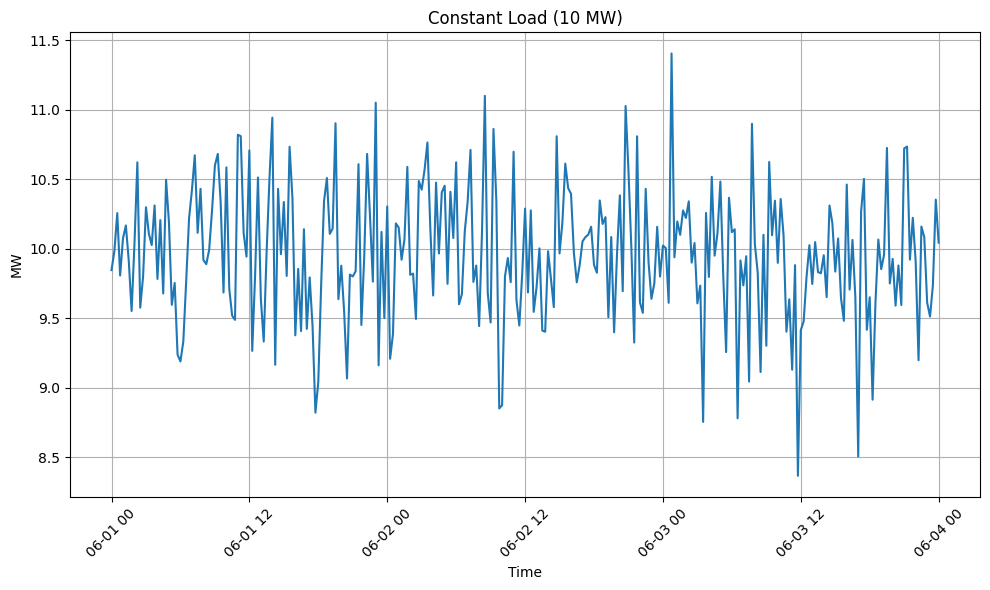

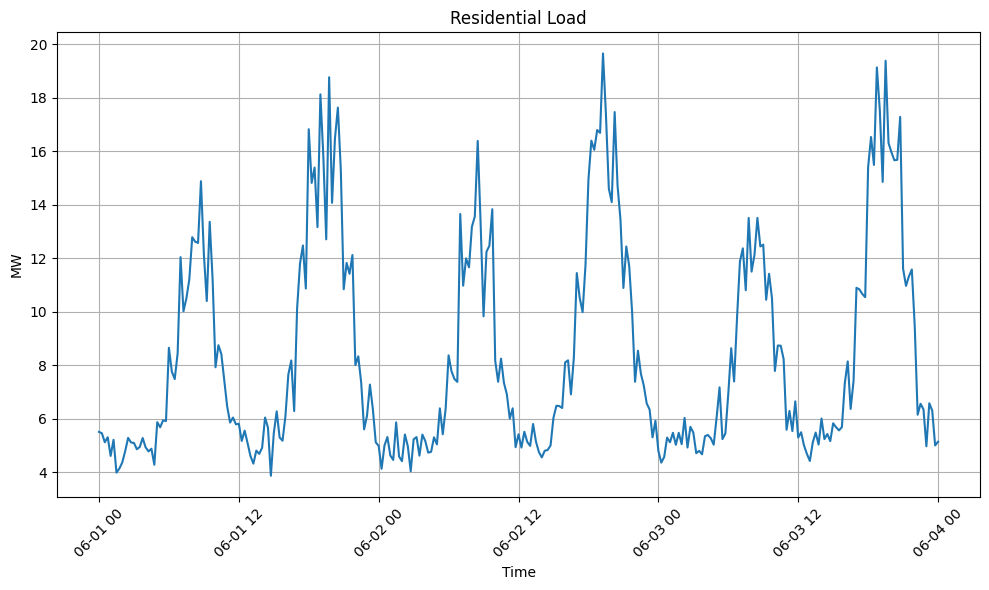

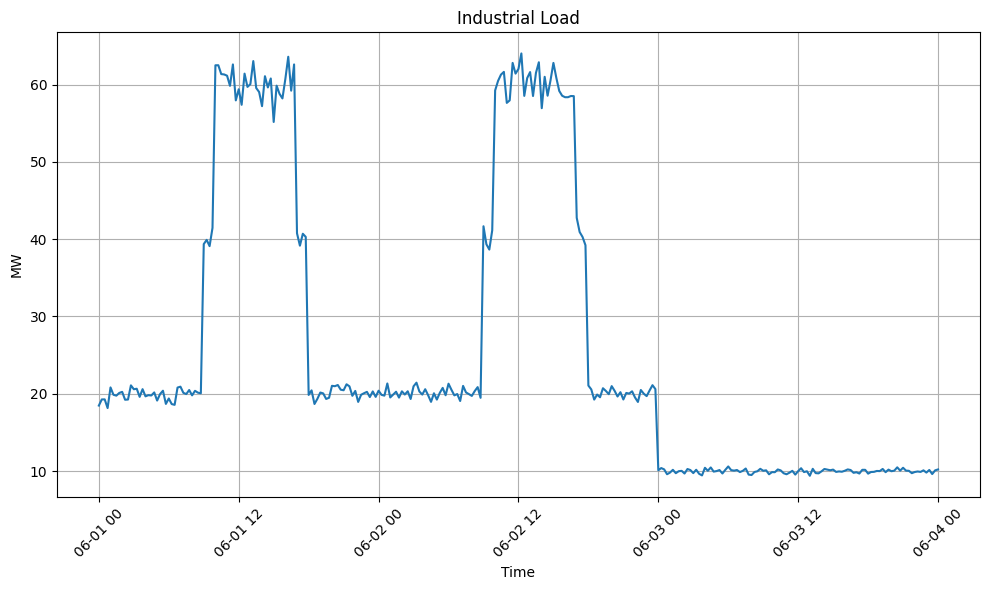

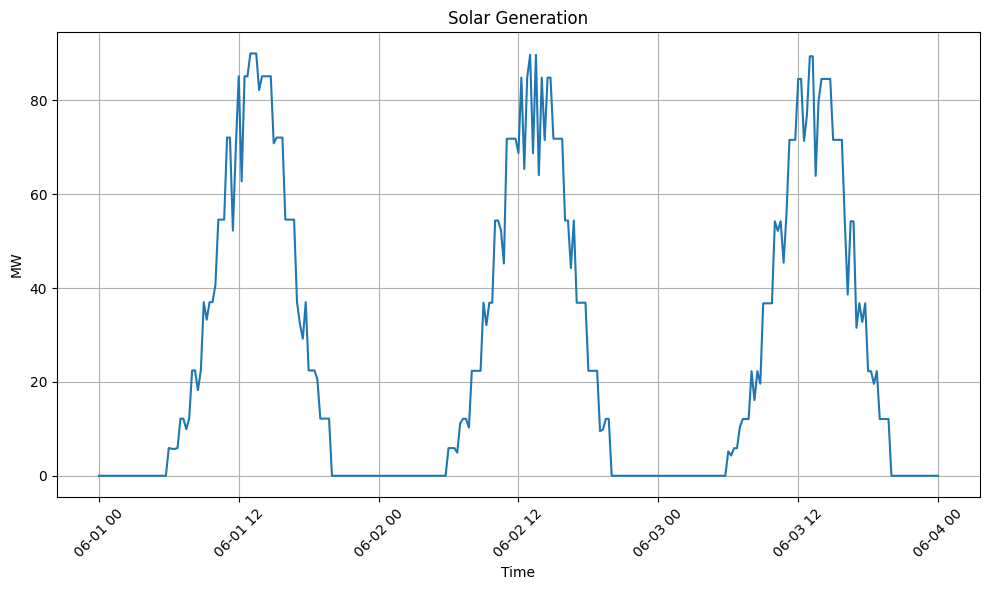

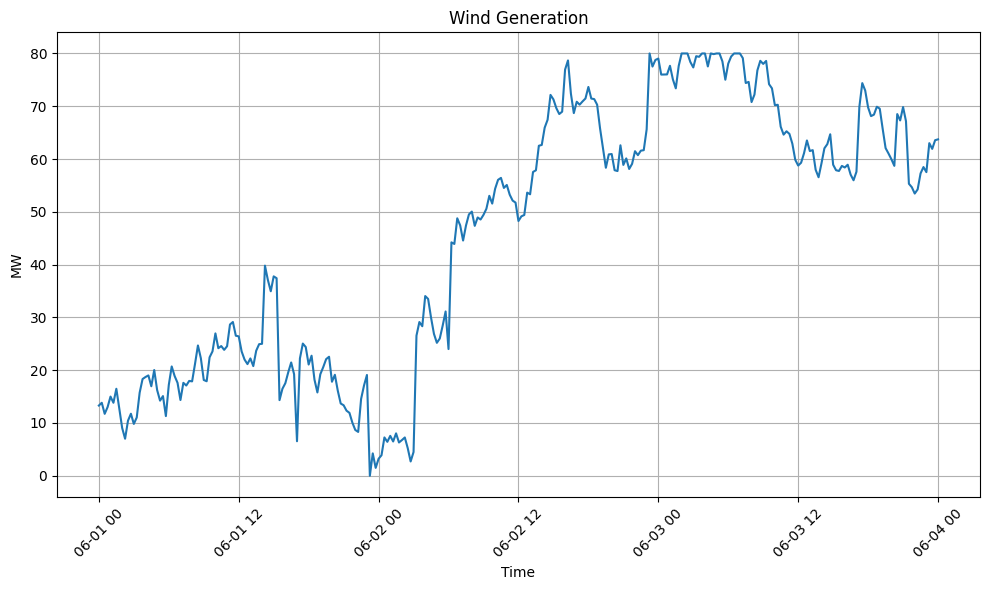


Combining profiles...


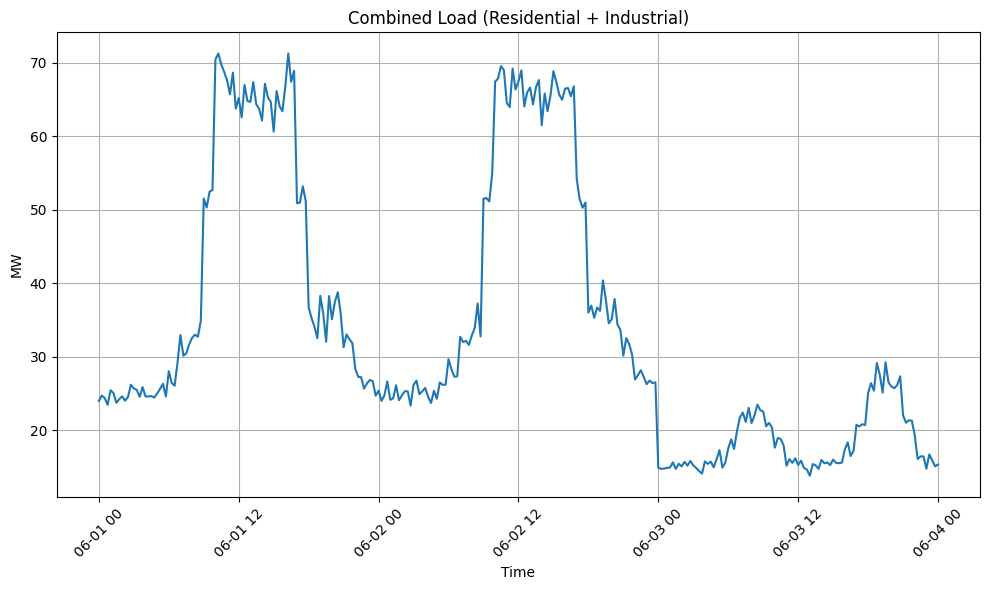

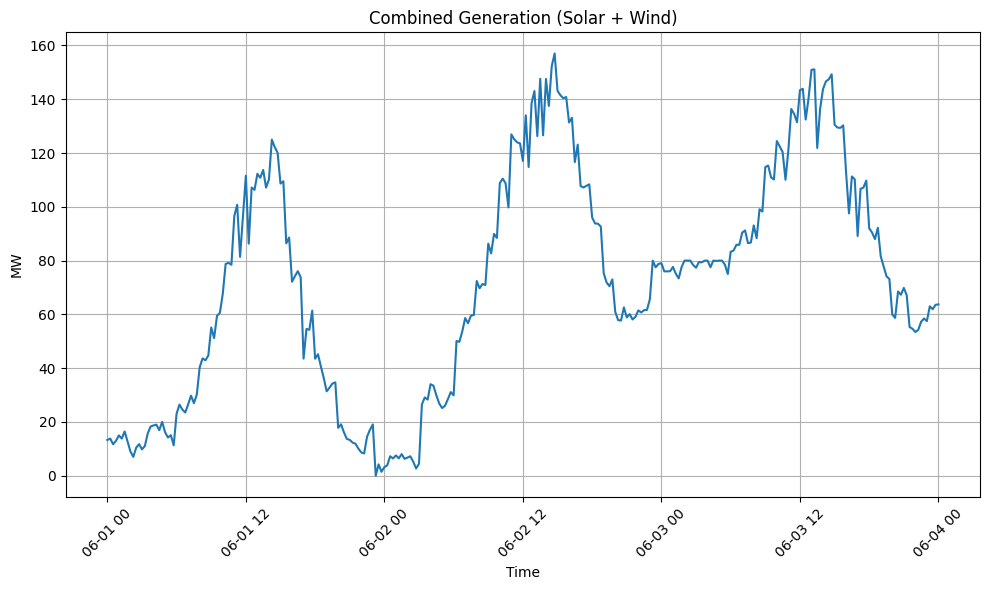

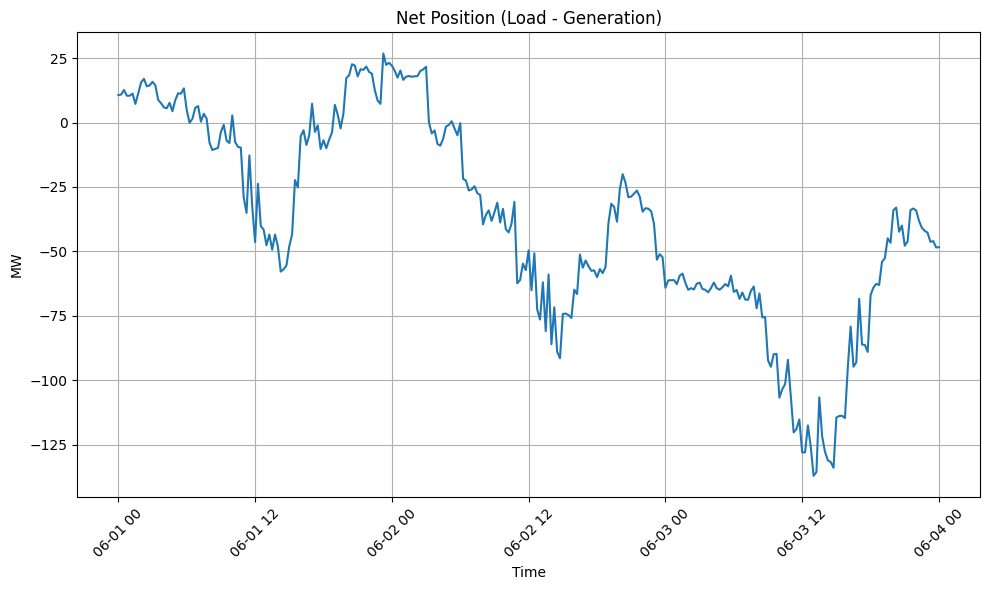


Profile Statistics:
Average constant load: 9.96 MW
Average residential load: 8.41 MW
Average industrial load: 25.56 MW
Average solar generation: 26.24 MW
Average wind generation: 45.48 MW
Average total load: 33.97 MW
Average total generation: 71.72 MW
Average net position: -37.75 MW


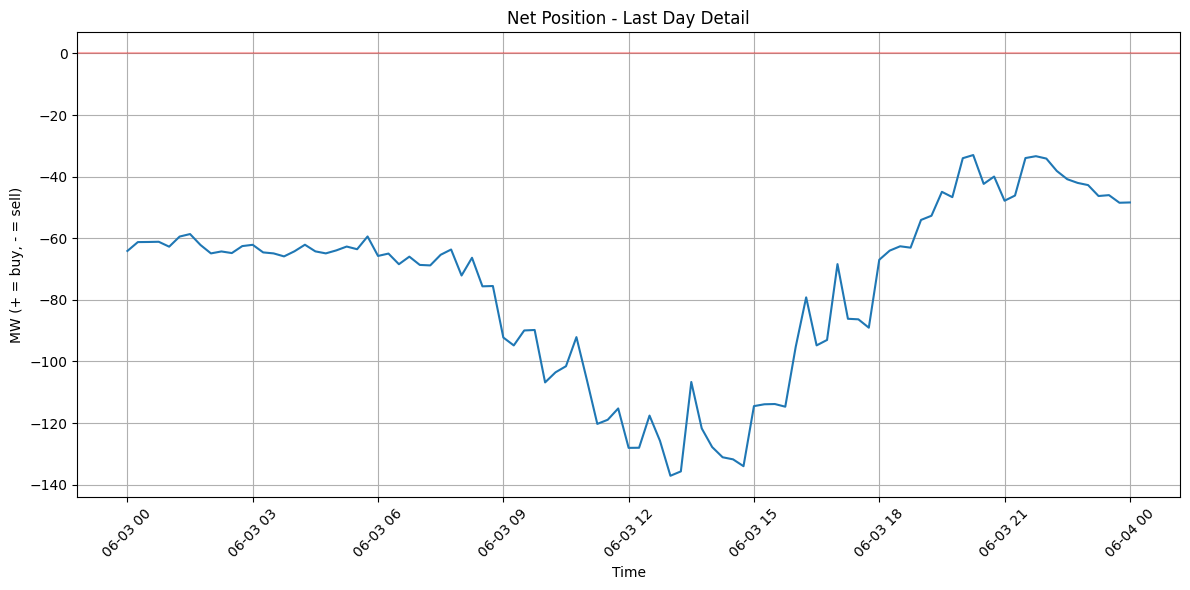

In [7]:
import datetime
import matplotlib.pyplot as plt
from src.load_profiles import (
    constant_profile, 
    residential_profile, 
    industrial_profile, 
    solar_generation, 
    wind_generation, 
    plot_profile, 
    combine_profiles
)

# Define time range for profiles (3 days)
start_time = datetime.datetime(2023, 6, 1)
end_time = datetime.datetime(2023, 6, 4)

# Generate different profile types
print("Generating profiles...")

# 1. Constant profile (10 MW with 5% noise)
constant = constant_profile(
    start_time=start_time,
    end_time=end_time,
    value=10.0,
    noise_factor=0.05
)
print(f"Constant profile: {len(constant)} datapoints")

# 2. Residential profile
residential = residential_profile(
    start_time=start_time,
    end_time=end_time,
    base_load=5.0,
    morning_peak=8.0,
    evening_peak=12.0,
    noise_factor=0.1
)
print(f"Residential profile: {len(residential)} datapoints")

# 3. Industrial profile
industrial = industrial_profile(
    start_time=start_time,
    end_time=end_time,
    base_load=20.0,
    peak_load=60.0,
    working_hours=(8, 18),
    weekend_factor=0.5
)
print(f"Industrial profile: {len(industrial)} datapoints")

# 4. Solar generation
solar = solar_generation(
    start_time=start_time,
    end_time=end_time,
    capacity=100.0,
    cloudiness=0.3
)
print(f"Solar generation profile: {len(solar)} datapoints")

# 5. Wind generation
wind = wind_generation(
    start_time=start_time,
    end_time=end_time,
    capacity=80.0,
    volatility=0.3
)
print(f"Wind generation profile: {len(wind)} datapoints")

# Plot individual profiles
print("\nPlotting individual profiles...")
plot_profile(constant, "Constant Load (10 MW)")
plot_profile(residential, "Residential Load")
plot_profile(industrial, "Industrial Load")
plot_profile(solar, "Solar Generation")
plot_profile(wind, "Wind Generation")

# Combine profiles
print("\nCombining profiles...")

# Net load (load minus generation)
total_load = combine_profiles([residential, industrial])
plot_profile(total_load, "Combined Load (Residential + Industrial)")

total_generation = combine_profiles([solar, wind])
plot_profile(total_generation, "Combined Generation (Solar + Wind)")

# Create generation profiles with negative values for proper combination
solar_neg = solar.copy()
solar_neg['value'] = -solar_neg['value']
wind_neg = wind.copy()
wind_neg['value'] = -wind_neg['value']

# Net position (positive = need to buy, negative = can sell)
net_position = combine_profiles([residential, industrial, solar_neg, wind_neg])
plot_profile(net_position, "Net Position (Load - Generation)")

# Print some statistics
print("\nProfile Statistics:")
print(f"Average constant load: {constant['value'].mean():.2f} MW")
print(f"Average residential load: {residential['value'].mean():.2f} MW")
print(f"Average industrial load: {industrial['value'].mean():.2f} MW")
print(f"Average solar generation: {solar['value'].mean():.2f} MW")
print(f"Average wind generation: {wind['value'].mean():.2f} MW")
print(f"Average total load: {total_load['value'].mean():.2f} MW")
print(f"Average total generation: {total_generation['value'].mean():.2f} MW")
print(f"Average net position: {net_position['value'].mean():.2f} MW")

# Show last day of net position profile in detail
last_day = net_position[net_position['timestamp'] >= end_time - datetime.timedelta(days=1)]

plt.figure(figsize=(12, 6))
plt.plot(last_day['timestamp'], last_day['value'])
plt.title("Net Position - Last Day Detail")
plt.xlabel("Time")
plt.ylabel("MW (+ = buy, - = sell)")
plt.grid(True)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd, requests, re

# after you have downloaded one file manually, paste the URL here
link = "https://download.eex-group.com/download/market-results/2025/01/DE-LU_INTRADAY_AUCTION_15min_202501.csv?X-Amz-Expires=600&X-Amz-Credential=..."

df = pd.read_csv(link)


ModuleNotFoundError: No module named 'requests'